<a href="https://colab.research.google.com/github/ktabata117/classmaterial_public/blob/master/econ_taba1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm         # tqdm is a nice library to visualize ongoing loops
import datetime
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass

In [ ]:
# Model parameters

β = 0.9 
γ = 2.0 
σ = 0.1  
ρ = 0.999
σ_r = 0.001
ρ_r = 0.2
σ_p = 0.0001
ρ_p = 0.999
σ_q = 0.0001
ρ_q = 0.999

σ_fp=  0.0001
σ_ex=0.0001
σ_ω=0.01

ρ_fp=0.9999
ρ_ex=0.8888
ρ_ω=0.9


σ_r = 0.001
ρ_r = 0.2
σ_p = 0.0001
ρ_p = 0.999
σ_q = 0.001
ρ_q = 0.9
σ_δ = 0.001
ρ_δ = 0.2
rbar = 1.04

In [ ]:
# Standard deviations for ergodic distributions of exogenous state variables
σ_e_r = σ_r/(1-ρ_r**2)**0.5
σ_e_p = σ_p/(1-ρ_p**2)**0.5
σ_e_q = σ_q/(1-ρ_q**2)**0.5
σ_e_δ = σ_δ/(1-ρ_δ**2)**0.5

σ_e_ex = σ_ex/(1-ρ_ex)**0.5
σ_e_ω=σ_ω/(1-ρ_ω)**0.5
σ_e_fp=σ_fp/(1-ρ_fp)**0.5
# bounds for endogenous state variable
wmin = 0.1
wmax = 4.0

In [ ]:
# Here is the  Fischer-Burmeister (FB) in TensorFlow:
min_FB = lambda a,b: a+b-tf.sqrt(a**2+b**2)

In [ ]:
# construction of neural network
layers = [
    tf.keras.layers.Dense(32, activation='relu', input_dim=8, bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.linear)
]
perceptron = tf.keras.Sequential(layers)

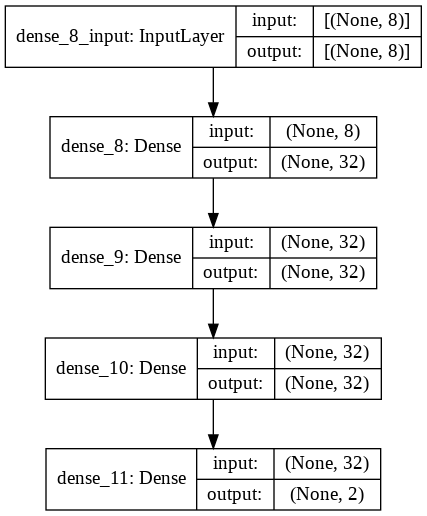

In [ ]:
# this cell requires graphviz (replace by UML plot)
tf.keras.utils.plot_model(perceptron, to_file='model.png', show_shapes=True)

In [ ]:
def dr(r: Vector, δ: Vector, q: Vector, p: Vector, w: Vector,ex:Vector,ω:Vector,fp:Vector)  -> Tuple[Vector, Vector]:

    # we normalize exogenous state variables by their 2 standard deviations 
    # so that they are typically between -1 and 1 
    r = r/σ_e_r/2
    δ = δ/σ_e_δ/2
    q = q/σ_e_q/2
    p = p/σ_e_p/2
    ex =ex/σ_e_ex/2
    #fc =fc/σ_e_fc/2
    ω =ω/σ_e_ω/2
    fp =fp/σ_e_fp/2

    # we normalze income to be between -1 and 1
    w = (w-wmin)/(wmax-wmin)*2.0-1.0

    # we prepare input to the perceptron
    s = tf.concat([_e[:,None] for _e in [r,δ,q,p,w,ex,ω,fp]], axis=1) # equivalent to np.column_stack #axisi=横に足す concat 結合

    x = perceptron(s) # n x 2 matrix 

    # consumption share is always in [0,1]
    ζ = tf.sigmoid( x[:,0] )
    
    # expectation of marginal consumption is always positive
    h = tf.exp( x[:,1] )

    
    return (ζ, h)

In [ ]:
wvec = np.linspace(wmin, wmax, 100)
# r,p,q,δ are zero-mean
ζvec, hvec = dr(wvec*0, wvec*0, wvec*0, wvec*0, wvec,wvec*0,wvec*0,wvec*0)

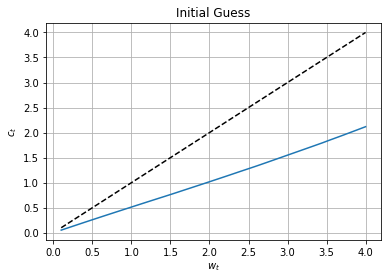

In [ ]:
plt.plot(wvec, wvec, linestyle='--', color='black')
plt.plot(wvec, wvec*ζvec)
plt.xlabel("$w_t$")
plt.ylabel("$c_t$")
plt.title("Initial Guess")
plt.grid()

In [ ]:
  def Residuals(e_r: Vector,\
               e_ex:Vector,\
               e_ω: Vector,\
               e_δ: Vector,\
               e_q: Vector, \
               e_p: Vector,\
               e_fp:Vector,\
               r: Vector,\
               δ: Vector,\
               q: Vector, \
               p: Vector, \
               fp:Vector,\
               w:Vector,\
               ω:Vector,\
               ex:Vector):

    # all inputs are expected to have the same size n
    n = tf.size(r)

    # arguments correspond to the values of the states today
    ζ, h = dr(r, δ, q, p, w,ex,ω,fp)  #　ex fc fp ω
   
    c = ζ*w #fasset(ζ)+domestic_asset（１－ζ）=w 
    
    # transitions of the exogenous processes
    rnext = r*ρ_r + e_r
    δnext  = δ*ρ_δ + e_δ
    pnext = p*ρ_p + e_p
    qnext = q*ρ_q + e_q
    ωnext =ω*ρ_ω+e_ω
    exnext = ex*ρ_ex+e_ex
    fpnext  = fp*ρ_fp+e_fp  
    rex =tf.exp(ex+p-fp)
    
     # C＜domestic asset;foreign asset=w 
    #fa=ω*w
    #rex= exp(p+ex-fp)
    ra  =r+ω*(ex-exnext)

    wnext= (tf.exp(pnext)*tf.exp(qnext)-c)/ωnext+(ω/ωnext)*w*rbar*tf.exp(ra)
    ζnext, hnext = dr(rnext, δnext, qnext, pnext, wnext,exnext,ωnext,fpnext)
    cnext =ζnext*wnext
    #fanext=ωnext*wnext
    #cf = (nex*rex+c)   #nex=(p/ex*pf)*cf-(ex*pf/p)*c  -- cf=rex*nex+c

    R1 = β*(cnext/c)**(-γ)*rbar*tf.exp(ra) - h
    R2 = min_FB(1-h,1-ζ)
    return (R1,R2)


In [ ]:
def Ξ(n): # objective function for DL training

    # randomly drawing current states
    r = tf.random.normal(shape=(n,), stddev=σ_e_r)
    δ = tf.random.normal(shape=(n,), stddev=σ_e_δ)
    p = tf.random.normal(shape=(n,), stddev=σ_e_p)
    q = tf.random.normal(shape=(n,), stddev=σ_e_q)
    w = tf.random.uniform(shape=(n,), minval=wmin, maxval=wmax)
    ex= tf.random.normal(shape=(n,),stddev=σ_e_ex)
    fp  = tf.random.normal(shape=(n,),stddev=σ_e_fp)
    ω =   tf.random.normal(shape=(n,),stddev=σ_e_ω)

 
    # randomly drawing 1st realization for shocks
    e1_r = tf.random.normal(shape=(n,), stddev=σ_r)
    e1_δ = tf.random.normal(shape=(n,), stddev=σ_δ)
    e1_p = tf.random.normal(shape=(n,), stddev=σ_p)
    e1_q = tf.random.normal(shape=(n,), stddev=σ_q)
    e1_ex = tf.random.normal(shape=(n,),stddev=σ_ex)
    e1_fp= tf.random.normal(shape=(n,),stddev=σ_fp)
    e1_ω= tf.random.normal(shape=(n,),stddev=σ_ω)           


    # randomly drawing 2nd realization for shocks
    e2_r = tf.random.normal(shape=(n,), stddev=σ_r)
    e2_δ = tf.random.normal(shape=(n,), stddev=σ_δ)
    e2_p = tf.random.normal(shape=(n,), stddev=σ_p)
    e2_q = tf.random.normal(shape=(n,), stddev=σ_q)
    e2_ex= tf.random.normal(shape=(n,),stddev=σ_ex)
    e2_fp= tf.random.normal(shape=(n,),stddev=σ_fp)
    e2_ω= tf.random.normal(shape=(n,),stddev=σ_ω)

    # residuals for n random grid points under 2 realizations of shocks
    R1_e1, R2_e1 = Residuals(e1_r, e1_δ, e1_p, e1_q,e1_ex,e1_fp,e1_ω, r, δ, q, p, w,ex,fp,ω)
    R1_e2, R2_e2 = Residuals(e2_r, e2_δ, e2_p, e2_q,e2_ex,e2_fp,e2_ω,r, δ, q, p, w,ex,fp,ω)

    # construct all-in-one expectation operator
    R_squared = R1_e1*R1_e2 + R2_e1*R2_e2 
     
    # compute average across n random draws
    return tf.reduce_mean(R_squared) 

In [ ]:
n = 127
v = Ξ(n)
v

<tf.Tensor: shape=(), dtype=float32, numpy=0.009230482>

In [ ]:
v.numpy()


0.009230482

In [ ]:
θ = perceptron.trainable_variables
print( str(θ)[:1000] ) # we truncate output

[<tf.Variable 'dense_8/kernel:0' shape=(8, 32) dtype=float32, numpy=
array([[-0.09689689,  0.34156257,  0.16658568, -0.09880731, -0.30432907,
         0.2082839 ,  0.29805785, -0.37711114, -0.305957  ,  0.04755226,
         0.1419313 ,  0.14083135, -0.27251536, -0.36340228, -0.16006793,
        -0.04937649,  0.18385494,  0.08760351, -0.07341719,  0.09558928,
         0.38325906, -0.08347335,  0.08913347, -0.04589847, -0.3523022 ,
         0.02950373, -0.3302408 ,  0.03339693, -0.31907976,  0.24070251,
         0.34655178,  0.3354373 ],
       [ 0.02771133,  0.09736153,  0.06403404,  0.00063992,  0.17147875,
         0.34189224,  0.12011963,  0.09869915, -0.27272257,  0.2777512 ,
         0.1997438 ,  0.30552107, -0.16112272, -0.09148988,  0.10578176,
         0.23569494, -0.36670092, -0.0402354 ,  0.10893357,  0.3428387 ,
         0.33673942, -0.25482488, -0.15865976, -0.2713072 , -0.27265352,
         0.36582905, -0.3740776 ,  0.10555968, -0.07165396,  0.05062604,
        -0.1776371 ,

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

In [ ]:
variables = perceptron.trainable_variables
optimizer = Adam()
#optimizer = SGD() # SGD can be used in place of Adam

In [ ]:
@tf.function
def training_step():

    with tf.GradientTape() as tape:
        xx = Ξ(n)

    grads = tape.gradient(xx, θ)
    optimizer.apply_gradients(zip(grads,θ))

    return xx

In [ ]:
def train_me(K):

    vals = []
    for k in tqdm(tf.range(K)):
        val = training_step()
        vals.append(val.numpy())
        
    return vals

In [ ]:
# with writer.as_default():
results = train_me(50000)

100%|██████████| 50000/50000 [01:19<00:00, 630.53it/s]


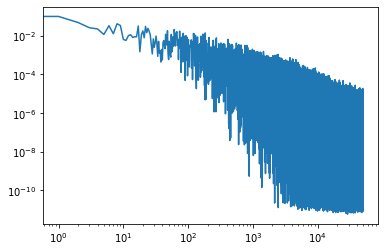

In [ ]:
plt.plot(np.sqrt( results))
plt.xscale('log')
plt.yscale('log')


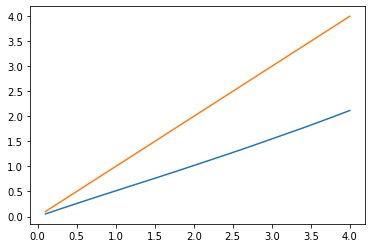

In [ ]:
wvec=np.linspace(wmin,wmax,100)
#ζvec, hvec = dr(wvec*0, wvec*0, wvec*0, wvec*0, wvec,wvec*0,wvec*0,wvec*0)
cons= ζvec*wvec
fasset=(wvec-cons)
plt.plot(wvec,cons)
plt.plot(wvec,wvec)


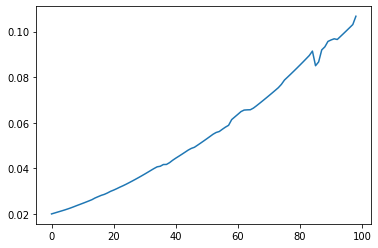

In [ ]:
fasset1=tf.exp(fasset)
#plt.plot(fasset1)
nex=np.diff(fasset1,n=1)
plt.plot(nex)